# Tutorials
https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Quick_demo_of_HuggingFace_version_of_Vision_Transformer_inference.ipynb
https://huggingface.co/docs/transformers/en/model_doc/trocr

Vision Text Dual-Encoder: CLIP and Contrastive Learning
https://github.com/huggingface/transformers/blob/main/examples/pytorch/contrastive-image-text/README.md
https://huggingface.co/blog/vision_language_pretraining
https://medium.com/@brianpulfer/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

Learn OpenCV: TrOCR Finetuning:
https://learnopencv.com/fine-tuning-trocr-training-trocr-to-recognize-curved-text/#aioseo-fine-tuning-trocr-on-curved-text

In [21]:
import numpy as np
import pandas as pd
import matplotlib as plt
import torch
#from transformers import ViTForImageClassification

In [22]:
## Seeding
# Define a set seed to make this process fully reproduceable
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

# Import and the model and processor


In [23]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
#import torch

# VISION TEXT ENCODER DECODER


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f" Using device: {device} : {torch.cuda.get_device_name(device)}")


#processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')

#model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

#model.save_pretrained("TrOCR")

 Using device: cuda : NVIDIA GeForce RTX 4070 Ti SUPER


In [24]:
# Configs
from dataclasses import dataclass

# Training config
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:         int = 16
    EPOCHS:             int = 15
    LEARNING_RATE:      float = 0.00005

# Dataset
@dataclass(frozen=True)
class DatasetConfig:
    Data_Source:        str = 'dataset/IM2LATEX-100K-HANDWRITTEN'
    Formulas:           str = 'dataset/IM2LATEX-100K-HANDWRITTEN/formulas.lst'
    Images_Dir:         str = 'dataset/IM2LATEX-100K-HANDWRITTEN/images/'

# Model config
@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-handwritten'

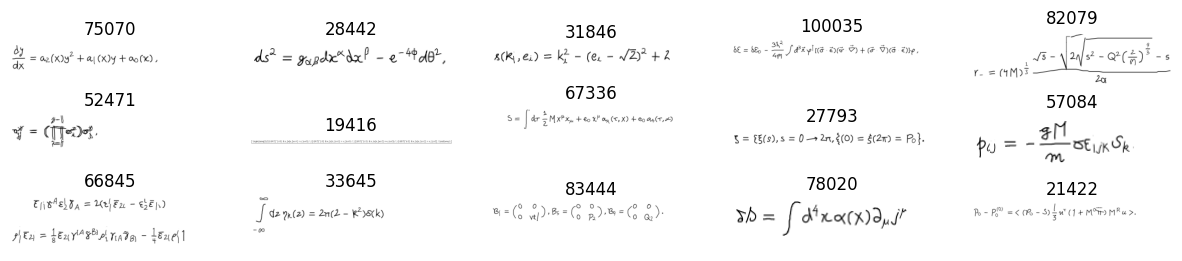

In [25]:
import matplotlib.pyplot as plt
import os

def visualize(dataset_path):
    plt.figure(figsize=(15, 3))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        images = os.listdir(f"{dataset_path}/images")
        image = plt.imread(f"{dataset_path}/images/{images[i]}")
        plt.imshow(image)
        plt.axis('off')
        plt.title(images[i].split('.')[0])
    plt.show()

visualize(DatasetConfig.Data_Source)

In [20]:
# Pandas dataset prep
import pandas as pd

try:
#    with open(list_file, 'r') as f:
#        self.formula_image_pairs = [line.strip().split() for line in f]
    with open(DatasetConfig.Formulas, 'r') as f:
        formulas = f.read().splitlines()
except FileNotFoundError:
    print(f"This file does not exist. {DatasetConfig.Formulas}")
    raise
#formulas
formulas_df = pd.DataFrame(formulas, columns=['formula'])
#formulas_df

train_df = pd.read_csv(
    os.path.join(DatasetConfig.Data_Source, 'train.lst'), header=None, sep=' '
)
train_df.rename(columns={0: 'image_no', 1: 'formula_no'}, inplace=True)
train_df = train_df.drop(train_df.columns[2], axis=1)
train_df = train_df.merge(formulas_df, left_on='formula_no', right_index=True)

test_df = pd.read_csv(
    os.path.join(DatasetConfig.Data_Source, 'test.lst'), header=None, sep=' '
)
test_df.rename(columns={0: 'image_no', 1: 'formula_no'}, inplace=True)
test_df = test_df.drop(test_df.columns[2], axis=1)
test_df = test_df.merge(formulas_df, left_on='formula_no', right_index=True)

val_df = pd.read_csv(
    os.path.join(DatasetConfig.Data_Source, 'val.lst'), header=None, sep=' '
)
val_df.rename(columns={0: 'image_no', 1: 'formula_no'}, inplace=True)
val_df = val_df.drop(val_df.columns[2], axis=1)
val_df = val_df.merge(formulas_df, left_on='formula_no', right_index=True)

train_df

,image_no,formula_no,formula
0,36003,37436,N^{2}=-\left[ r_{++}\left( r_{++}+r_{+}\right)...
1,48127,50043,-i\Omega_m \longrightarrow p^0 + i\varepsilon ...
2,79113,82314,"f=1-3a^{2}/2\rho ^{2}\quad ,\quad \rho \righta..."
3,54980,57179,\label{psi1} \Psi_1(r) = \frac{am}{M^2} K_1(...
4,32638,33934,"-\frac{1}{\kappa}R(V,\omega ) + L_{m}(V,\omega..."
...,...,...,...
79547,86079,89587,c_2^L=(2\pi)^{-1/2} 5^{5/2} \exp \left[ \frac{...
79548,46134,47969,\sum_N \sum_{\lambda\atop{|\lambda|=N}} S_\la...
79549,73398,76373,"(\psi^\alpha)^\dagger\equiv\bar\psi_\alpha\,,"
79550,52959,55081,(\eta M)_{\mu\nu}\tilde{\psi}_{-1/2}^\mu\psi_{...


In [14]:
# Image collation and preprocessing function

import torch
import random

def collate_function(batch):
    images = [item['image'] for item in batch]
    formulas = [item['formula'] for item in batch]

    # Get the maximum height and width in the batch
    max_height = max(image.size(1) for image in images)
    max_width = max(image.size(2) for image in images)

    # Pad the images to the maximum height and width in the batch
    processed_images = []
    for image in images:
        height, width = image.size(1), image.size(2)

        ## Scale images to match the same width and height of the largest image in the batch
        # Calculate the new height and width of the padded image
        if (max_height - height)/height  < (max_width - width)/width:
            scaling_factor = max_height / height
        else:
            scaling_factor = max_width / width
        
        # scale the new height and widht
        new_height = int(height * scaling_factor)
        new_width = int(width * scaling_factor)

        resized_image = torch.nn.functional.interpolate(
            image.unsqueeze(0), 
            size = (new_height, new_width), 
            mode='bilinear'
        ).squeeze(0)
        
        ## min-max scaling to normalize all images
        min_val = torch.min(resized_image)
        max_val = torch.max(resized_image)
        # Prevent division by zero
        if max_val > min_val:
            resized_image = (resized_image - min_val) / (max_val - min_val)
        else:
            # If max == min, just set to zeros or a constant value
            resized_image = torch.zeros_like(resized_image)
        
    
        # pad and append 5 images with random displacement within batch maximum image size bounds
        for _ in range(5):
            ## Pad images to match the same width and height
            padded_image = torch.ones(image.size(0), max_height, max_width)
            # calculate offsets
            off_x = int(random.random() * (max_width - new_width)) if max_width > new_width else 0
            off_y = int(random.random() * (max_height - new_height)) if max_height > new_height else 0

            padded_image[:, off_y:(new_height + off_y), off_x:(new_width + off_x)] = resized_image

            # add images into processed images array
            processed_images.append(padded_image)
    
    # Stack the resized images
    resized_images = torch.stack(processed_images)

    return {'image': resized_images, 'formula': formulas}

In [15]:
# Assemble dataset
import os
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms


# ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ 
  # PATHS AND PRESETS
   
#images_folder = "dataset/IM2LATEX-100K-HANDWRITTEN/images"
#train_list = "dataset/IM2LATEX-100K-HANDWRITTEN/train.lst"
#test_list = "dataset/IM2LATEX-100K-HANDWRITTEN/test.lst"
#val_list = "dataset/IM2LATEX-100K-HANDWRITTEN/val.lst"
#formulas_file = "dataset/IM2LATEX-100K-HANDWRITTEN/formulas.lst"
#batch_size = 3

#output_dir = "output/"

# ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ ==== ++++ 

class IM2LATEXDataset(Dataset):
    def __init__(self, root_dir, df, processor, formulas_file, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

        try:
        #    with open(list_file, 'r') as f:
        #        self.formula_image_pairs = [line.strip().split() for line in f]
            with open(formulas_file, 'r') as f:
                self.formulas = f.read().splitlines()
        except FileNotFoundError:
            print(f"This file does not exist. {formulas_file}")
            raise
        #print(self.formulas[11869], self.formula_image_pairs[70975])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            # get formula_image pair
            image_no = self.df['image_no'][idx]
            formula = self.df['formula'][idx]

            # create image path from image name
            img_path = os.path.join(DatasetConfig.Images_Dir, image_no + ".png")

            #attempt to open images and convert to greyscale
            try:
                image = Image.open(img_path)#.convert('L')
            except FileNotFoundError:
                print(f"Image not found: {img_path}")
                raise

            # transform image if transform exists
            if self.transform:
                image = self.transform(image)

            # return pixel values
            pixel_values = self.processor(image, return_tensors='pt').pixel_values

            # process labels
            labels=self.processor.tokenizer(
                formula,
                padding='max_length',
                max_length=self.max_target_length
            ).input_ids
            # use '-100' as a padding token
            labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

            # make encoding
            encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
            return encoding
            #return {"image": image, "formula": formula}
        
        except Exception as e:
            # catch imageloading exceptions
            print(f"Error in __getitem__ at index {idx}: {e}")
            # print(f"Image-formula pair: {self.formula_image_pairs[idx]}")
            raise

#def load_im2latex_dataset(images_folder, train_list, test_list, val_list, formulas_file, batch_size=batch_size, transform=None):
#    
#    # create transforms for image
#    if transform is None:
#        transform = transforms.Compose([
#            transforms.ToTensor(),
#            transforms.Normalize(mean=[0.485], std=[0.229]),
#            #transforms.Resize((224, 224))
#        ])
#    
#    # create train, test, validation datasets
#    train_dataset = IM2LATEXDataset(images_folder, train_list, formulas_file, transform)
#    test_dataset = IM2LATEXDataset(images_folder, test_list, formulas_file, transform)
#    val_dataset = IM2LATEXDataset(images_folder, val_list, formulas_file, transform)
#    
#    # load datasets
#    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_function)
#    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_function)
#    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_function)
#    
#    return train_loader, test_loader, val_loader
#
#
## run dataset loader
#train_loader, test_loader, val_loader = load_im2latex_dataset(images_folder, train_list, test_list, val_list, formulas_file, batch_size=batch_size)

In [16]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator

processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
train_dataset = IM2LATEXDataset(
    DatasetConfig.Data_Source, 
    train_df, 
    processor=processor, 
    formulas_file=DatasetConfig.Formulas
)

test_dataset = IM2LATEXDataset(
    DatasetConfig.Data_Source, 
    test_df, 
    processor=processor, 
    formulas_file=DatasetConfig.Formulas
)

val_dataset = IM2LATEXDataset(
    DatasetConfig.Data_Source, 
    val_df, 
    processor=processor, 
    formulas_file=DatasetConfig.Formulas
)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
print(f"{total_trainable_params:,} training parameters.")

	
# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id
 
 
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.48.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 1024,
  "decode

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense):

In [18]:
# pretraining setup

# optimizer
from torch.optim import AdamW
import evaluate

optimizer = AdamW(
    model.parameters(),
    lr=TrainingConfig.LEARNING_RATE,
    weight_decay=0.0005
)

# Character error
cer_metric = evaluate.load('cer')

def compute_cer(pred):
    label_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    eval_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    fp16=True,
    output_dir='output/',
    logging_strategy='epoch',
    save_total_limit=5,
    report_to='tensorboard',
    num_train_epochs=TrainingConfig.EPOCHS
)

In [26]:

# Training
trainer = Seq2SeqTrainer(
    model = model,
    tokenizer = processor.feature_extractor,
    args = training_args,
    compute_metrics = compute_cer,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    data_collator = default_data_collator
)

res =trainer.train()

/home/kit/Documents/handwriting2Markdown/.venv/lib/python3.12/site-packages/transformers/models/trocr/processing_trocr.py:152: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/tmp/ipykernel_16782/2666587125.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Error in __getitem__ at index 41922: ufunc 'add' did not contain a loop with signature matching types (dtype('int64'), dtype('<U4')) -> None


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('int64'), dtype('<U4')) -> None

In [7]:
model = VisionEncoderDecoderModel.from_pretrained(output_dir)

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')

model.to(device)

# Preprocess the image
batch = next(iter(train_loader))
pixel_values = processor(batch['image'], return_tensors="pt").pixel_values.to(device)

# Run inference
with torch.no_grad():
    generated_ids = model.generate(pixel_values)

# Decode the generated IDs to text
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

#plt.imshow(pixel_values.cpu()[0])
#pixel_values.cpu()[0]
#plt.show()

# Print the output
print("Generated Text:", generated_text)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

Generated Text: ['\\label{eq:covder}          ', '\\label{eq:covder}          ', '\\label{eq:covder}          ', '\\label{eq:covder}          ', '\\label{eq:covder}          ', '\\label{eq:covder}          ', '\\label{eq:covder}          ', '\\label{eq:covder}          ', '\\label{eq:covder}          ', '\\label{eq:covder}          ', '\\label{eq:covder}          ', '\\label{eq:covder}          ', '\\label{eq:covder}          ', '\\label{eq:covder}          ', '\\label{eq:covder}          ']


In [8]:
# Training 
import torch.optim as optim
from torch.amp import autocast, GradScaler
import os
torch.cuda.empty_cache()


# DSA blocking
#export CUDA_LAUNCH_BLOCKING=1
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
model.to(device)

# Gradscaler
scaler = GradScaler()

# Set up optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Hyper Parameters
accumulation_steps = 4 # next step try cumulative loss
num_epochs = 3

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        
        # Move data to device
          # Texts should be in a format suitable for the tokenizer

        # Training
        model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
        model.config.pad_token_id = processor.tokenizer.pad_token_id
        model.config.vocab_size = model.config.decoder.vocab_size

        # Encode texts
        #text_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(device)
        #processor(images, texts)
        pixel_values = processor(batch['image'], return_tensors="pt").pixel_values.to(device) #images = batch['image'].to(device)
        #torch.tensor()
        labels = processor.tokenizer(text = batch['formula'], max_length=512, truncation=True, return_tensors="pt",padding=True).input_ids.to(device)

        # Forward pass (with mixed precision)
        with autocast(device_type='cuda'):
          outputs = model(pixel_values=pixel_values, labels=labels)
          #print("Model output shape:", outputs.size)  # Check output shape
          #print("Labels:", labels)  # Check label values
          # Compute loss (you may need to define a suitable loss function)
          loss = outputs.loss  # Assuming the model returns a loss attribute

        # Backward pass and optimization
        optimizer.zero_grad()
        scaler.scale(loss).backward() # loss.backward()
        scaler.step(optimizer) # optimizer.step()
        scaler.update()
        #print("Batch run")

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the model and processor
model.save_pretrained(output_dir)
processor.save_pretrained(output_dir)

OutOfMemoryError: CUDA out of memory. Tried to allocate 226.00 MiB. GPU 0 has a total capacity of 15.55 GiB of which 27.19 MiB is free. Including non-PyTorch memory, this process has 14.45 GiB memory in use. Of the allocated memory 13.99 GiB is allocated by PyTorch, and 196.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)